In [29]:
import sys, os

import matplotlib  
matplotlib.use('Agg')  

from matplotlib.pyplot import savefig

%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from cobra.io.sbml import create_cobra_model_from_sbml_file
from cobra.io.sbml import write_cobra_model_to_sbml_file

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_null',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import numpy as np
from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand

print "I'm using scipy version:" 
scipy.__version__

#### self-defined functions to find fluxes shifted between different sampling distributions
from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore


I'm using scipy version:


/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173 UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



In [98]:
import fluxShift
reload(fluxShift)
from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore


In [3]:
model = cobra.io.load_json_model("HNC47.json")
react_id = "RecombinantProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Recombinant protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0

metabolites = ['ala__L_c','cys__L_c','asp__L_c','glu__L_c','phe__L_c','gly_c','his__L_c','ile__L_c','lys__L_c','leu__L_c','met__L_c','asn__L_c','pro__L_c','gln__L_c','arg__L_c','ser__L_c','thr__L_c','val__L_c','trp__L_c','tyr__L_c','atp_c','adp_c','pi_c']
coefficient1 = [-6,-6,-9,-17,-9,-11,-5,-4,-17,-17,-3,-11,-19,-11,-6,-24,-14,-23,-4,-8,-4.306*224,964.544,965.544]
coefficient2 = [-0.513689,-0.09158,-0.241055,-0.26316,-0.185265,-0.612638,-0.094738,-0.290529,-0.343161,-0.450531,-0.153686,-0.241055,-0.221055,-0.26316,-0.295792,-0.215792,-0.253687,-0.423162,-0.056843,-0.137896,-23.03053,23.03053,23.03053]
for i in range(0,len(metabolites)):
    metabolite = model.metabolites.get_by_id(metabolites[i])
    reaction.add_metabolites({metabolite:coefficient1[i]}) 

    reaction.gene_reaction_rule = ''
model.add_reaction(reaction)

react_id = "BiomassProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Biomass protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0
for i in range(0,len(metabolites)):
    metabolite = model.metabolites.get_by_id(metabolites[i])
    reaction.add_metabolites({metabolite:coefficient2[i]}) 

model.add_reaction(reaction)

In [4]:
print len(model.reactions)

2786


In [5]:
print len(model.metabolites)

1973


In [5]:
coefficient1[i]

965.544

In [7]:
m = model
m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
m.reactions.EX_glc__D_e.lower_bound = -0.5

# Find Loops/zero flux reactions in M model
loops = []
read_to_struct =[]
for r in m.reactions:
    r.objective_coefficient = 1.0  
    m.optimize()
    if m.solution.f > 100:
        read_to_struct.append({'reaction':r.id, 'flux':m.solution.f})
        loops.append(r.id)
    
    r.objective_coefficient = 0

DF_erroneous_fluxes = pd.DataFrame(read_to_struct)

print "Finished 1"
#  search for zero flux reactions

opt_fract = 0.9

from cobra.flux_analysis.variability import flux_variability_analysis
flux_var = flux_variability_analysis(m, fraction_of_optimum=opt_fract)

removed = []
read_to_struct = []

for r in m.reactions:
    # 1 fix numerical errors
    if flux_var[r.id]['minimum'] > flux_var[r.id]['maximum']:
        min_val = np.round(flux_var[r.id]['minimum'],9)
        max_val = np.round(flux_var[r.id]['maximum'],9)
        flux_var[r.id]['minimum'] = max_val
        flux_var[r.id]['maximum'] = min_val
        
    # 2 constrain bounds to FVA results
    r.lower_bound = flux_var[r.id]['minimum']
    r.upper_bound = flux_var[r.id]['maximum']
    
    # 3 remove reactions that cannot carry flux
    if r.lower_bound==0 and r.upper_bound==0:
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
        m.optimize()
        
        if m.solution.f == None:
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'no'})
        else:
            removed.append(r.id)
            m.remove_reactions(r)
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'yes'})
            
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0   
        
DF_zero_flux_reactions = pd.DataFrame(read_to_struct)


Finished 1


cobra/core/Model.py:306 UserWarning: need to pass in a list


In [8]:
## Remove reactions from sampling dataframes
reactions_to_remove = DF_zero_flux_reactions.reaction[DF_zero_flux_reactions['removed?']=='yes'].tolist() + DF_erroneous_fluxes.reaction.tolist()
print "number of total reactions:", len(DF_zero_flux_reactions[DF_zero_flux_reactions['removed?']=='yes'])+len(DF_erroneous_fluxes.reaction)


number of total reactions: 750


In [102]:
def mcmc_tab2pandas(strain):
    if strain == 'Control':
        file1 = 'sampling_%s_p1.tab'%strain
        file2 = 'sampling_%s_p2.tab'%strain      
    else:
        file1 = 'sampling_Control_%s.tab'%strain
        file2 = 'sampling_20aas_%s.tab'%strain
    
    flux_dist1 = np.loadtxt(file1,delimiter="\t",skiprows=1)
    flux_dist2 = np.loadtxt(file2,delimiter="\t",skiprows=1)

    print "Sample size for %s I:"%strain, flux_dist1.shape
    print "Sample size for %s II:"%strain, flux_dist2.shape
    
    # now convert flux_dist array into pandas df with reaction field
    
    model_rxns=[]

    samples1 = defaultdict(list)
    samples2 = defaultdict(list)
    
    tmp_array = []
    for react in model.reactions:
        tmp_array.append(react.id)

    count = 0
    for i in tmp_array:
        rxn_name = str(i)
        model_rxns.append(str(i))
    
        samples1[rxn_name] = flux_dist1[count,:]
        samples2[rxn_name] = flux_dist2[count,:]
    
        count +=1

    # convert to dataframes    
    df_samples1 = pd.DataFrame(samples1)
    df_samples2 = pd.DataFrame(samples2)  

    print "number of reactions in df:", len(model_rxns)

    return (df_samples1,df_samples2)

################################################################################


In [10]:
mcmc_reduced_dict_p1 = {}
mcmc_reduced_dict_p2 = {}

mcmc_p1_dict = {}
mcmc_p2_dict = {}


In [11]:
mylegend = ["Control","20aas"]

In [12]:
for strain in mylegend:
    (mcmc_p1_dict[strain],mcmc_p2_dict[strain]) = mcmc_tab2pandas(strain)
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    df_reduced_p2 = remove_unwanted_rxns(mcmc_p2_dict[strain],reactions_to_remove)
    #df_reduced_p3 = remove_unwanted_rxns(mcmc_p3_dict[strain])

    ## testing
    # df_reduced_p1 = remove_unwanted_rxns(df_p1_samples,reactions_to_remove)
    # df_reduced_p2 = remove_unwanted_rxns(df_p2_samples,reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    mcmc_reduced_dict_p2[strain] = df_reduced_p2
    #mcmc_reduced_dict_p3[strain] = df_reduced_p3
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p2[strain].shape
    #print "Strain", strain, shape(mcmc_reduced_dict_p3[strain])


Sample size for Control phase I: (2786, 5000)
Sample size for Control phase II: (2786, 5000)
number of reactions in df: 2134
Strain Control (5000, 2036)
Strain Control (5000, 2036)
Sample size for 20aas phase I: (2786, 5000)
Sample size for 20aas phase II: (2786, 5000)
number of reactions in df: 2134
Strain 20aas (5000, 2036)
Strain 20aas (5000, 2036)


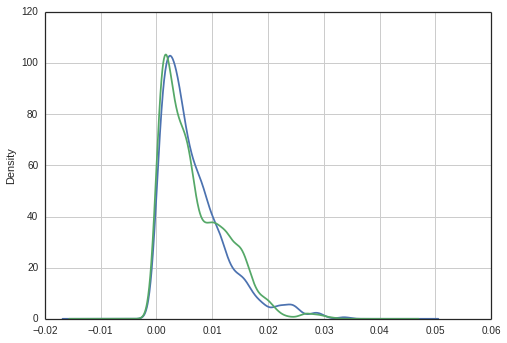

In [13]:
react = 'ENO'

mcmc_reduced_dict_p1['20aas'][react].plot(kind='density')
mcmc_reduced_dict_p2['20aas'][react].plot(kind='density')

In [14]:
#########################################################

# Perform further pruning of flux distributions
# Note: none of the remaining reactions have a significant amount of fluxes above the threshold:
#       No reactions have fluxes greater than 10 x glc uptake for > 99% of flux states
#       No reactions have fluxes greater than 20 x glc uptake

df_rxns_removed_p1 = {}
df_rxns_removed_p2 = {}

df_rxns_high_flux_remain_p1 = {}
df_rxns_high_flux_remain_p2 = {}

for strain in mcmc_reduced_dict_p1.keys():
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    [mcmc_reduced_dict_p2[strain], df_rxns_removed_p2[strain], df_rxns_high_flux_remain_p2[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p2[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape


shape before pruning Control: (5000, 2036)
shape after pruning Control: (5000, 1964)
shape before pruning Control: (5000, 2036)
shape after pruning Control: (5000, 1966)
shape before pruning 20aas: (5000, 2036)
shape after pruning 20aas: (5000, 1966)
shape before pruning 20aas: (5000, 2036)
shape after pruning 20aas: (5000, 1965)


In [17]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['20aas']

for i in df.index:
    if df['percent of states with flux < 10'][i] < 9900:
        print df['react_id'][i], df['percent of states with flux < 10'][i]

for i in df.index:
    if df['percent of states with flux < 10'][i] <10000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]


AOBUTDs 99
APRAUR 0
ARBt3ipp 0
AST 0
ATPM 0
ATPPRT 0
BTNtex 0
BTS5 0
CLt3_2pp 0
CMtpp 0
CO2tex 0
CO2tpp 0
DAPtex 0
DASYN141 0
DHORD5 68
DHORDfum 65
DIMPtex 0
DTMPK 0
DURItex 0
EX_indole_e 2
EX_ins_e 2
EX_tartr__L_e 55
EX_thr__L_e 2
FDH5pp 0
FE2abcpp 0
FE2t3pp 0
FE3HOXUtex 0
FE3HOXUtpp 0
FE3HOXabcpp 0
FLDR2 0
FORt2pp 0
GLYALDDr 0
I2FE2SS 2
IGPS 2
L_LACtex 0
MCTP1Bpp 0
MDDCP4pp 185
MDDCP5pp 1687
MDH 77
MEOHtex 0
MEOHtrpp 77
METSOX1tex 99
MINCYCtex 0
MINCYCtpp 41
MLDEP2pp 0
MN2tpp 256
MN6PP 256
MOHMT 0
MOX 0
MPTAT 0
NNATr 2
NOVBCNtex 0
NOVBCNtpp 0
NOtpp 0
NTD1 0
NTD10 0
NTD11 0
NTD12 0
NTD1pp 0
OCTDPS 0
OGMEACPD 0
ORNabcpp 0
PA120abcpp 0
PA140abcpp 0
PAPA180pp 0
PAPA181pp 15
PAPSR2 0
PGPP180 0
SULFACtex 0
SULabcpp 0
AOBUTDs 793.846589461
APRAUR 999.890305213
ARBt3ipp 934.267572535
AST 934.534246286
ATPM 764.665931974
ATPPRT 764.665861791
BTNtex 888.239109895
BTS5 999.759674441
CLt3_2pp 985.413496915
CMtpp 972.913102143
CO2tex 999.998950915
CO2tpp 820.427802557
DAPtex 934.313811257
DASYN14

In [19]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given strain
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1_p2 = {}
#flux_stats_dict_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        flux_stats_dict_p1_p2[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain], m, 1, 2)
        #flux_stats_dict_p2_p3[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain], m, 2, 3)

# Note: here we have the mean, median and std for the flux distributions in phases 1 and 2.
# The pval indicates whether the sample difference between these two states is significant.
flux_stats_dict_p1_p2['20aas'][0:3]


strain: Control
strain: 20aas


,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,2.62e-05,2.62e-05,1.30e-08,8.20e-06,8.19e-06,1.70e-08,4.00e-04,DM_4crsol_c
1,1.98e-04,1.56e-04,1.46e-04,1.43e-04,1.09e-04,1.19e-04,7.66e-01,DM_5drib_c
2,1.24e-11,1.90e-13,2.57e-11,8.93e-12,6.73e-12,1.00e-11,7.20e-01,DM_amob_c


Beta-ketoacyl-ACP synthase
['Control', '20aas']
(5000, 1964)


ValueError: array must not contain infs or NaNs

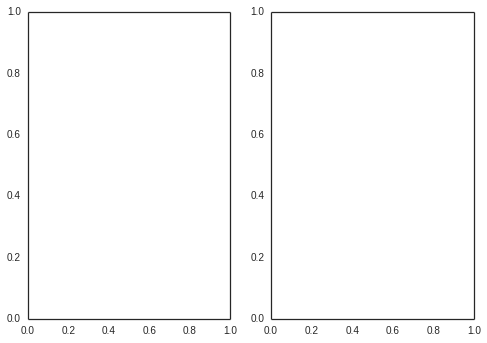

In [99]:
# Plot Shifts

react = 'KAS14'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2, react, 2, -1, 8)


In [24]:
# Classify Flux 
flux_stats_dict_p1_p2['20aas'][0:1]

flux_shift_stats_dict ={}
m_significant_shifts_dict ={}

for strain in flux_stats_dict_p1_p2.keys():
    print "strain:", strain
    df = flux_stats_dict_p1_p2[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict[strain] = df
    m_significant_shifts_dict[strain] = change
    
print m_significant_shifts_dict['20aas'].reaction.values

m_significant_shifts_dict['20aas'].subsystem.value_counts()


strain: Control
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1632
do shift 26 

strain: 20aas
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1630
do shift 28 

['2AGPEAT181' '2AGPGAT120' 'ASPO4' 'ASPO5' 'DHFS' 'FA161ACPHi' 'FA80ACPHi'
 'GTPDPK' 'HPYRRy' 'KAS14' 'LALDO2x' 'LIPAHTex' 'LPLIPAL2ATE160' 'MECDPS'
 'MEPCT' 'METSOXR2' 'MTHFD' 'NNDPR' 'NTD5' 'P5CR' 'SPMS' 'TDP' 'UM3PL'
 'UM4PCP' 'CHITPH' 'NMNR' 'PUNP7' 'DSCLCOCH']


Cofactor and Prosthetic Group Biosynthesis     10
Glycerophospholipid Metabolism                  3
Cell Envelope Biosynthesis                      2
Nucleotide Salvage Pathway                      2
Arginine and Proline Metabolism                 2
Murein Recycling                                2
Alternate Carbon Metabolism                     2
Methionine Metabolism                           1
Folate Metabolism                               1
Membrane Lipid Metabolism                       1
Methylglyoxal Metabolism                        1
Lipopolysaccharide Biosynthesis / Recycling     1
dtype: int64

In [106]:
print m_significant_shifts_dict['Control'].reaction.values

m_significant_shifts_dict['Control'].subsystem.value_counts()

['2AGPEAT181' 'APH181' 'ASPO4' 'ASPO5' 'DHFS' 'FA161ACPHi' 'FA80ACPHi'
 'GTPDPK' 'HSDy' 'LALDO2x' 'LALDO3' 'LIPAHTex' 'MECDPS' 'MEPCT' 'METSOXR2'
 'NNDPR' 'NTD5' 'P5CR' 'PSD141' 'SPMS' 'TDP' 'UM4PCP' 'CHITPH' 'UPLA4NT'
 'NMNR' 'DSCLCOCH']


Cofactor and Prosthetic Group Biosynthesis     10
Cell Envelope Biosynthesis                      3
Glycerophospholipid Metabolism                  3
Arginine and Proline Metabolism                 2
Methylglyoxal Metabolism                        2
Methionine Metabolism                           1
Nucleotide Salvage Pathway                      1
Alternate Carbon Metabolism                     1
Murein Recycling                                1
Threonine and Lysine Metabolism                 1
Lipopolysaccharide Biosynthesis / Recycling     1
dtype: int64

Mean: 0.0343890438966
Median: 6e-05
std: 0.359405557781
Factor x chosen: 0.5
Threshold up (mean + x*std):  0.214091822787
Threshold down (mean - x*std): -0.145313734994
Percent of population above/below threshold: 0.0198436560433


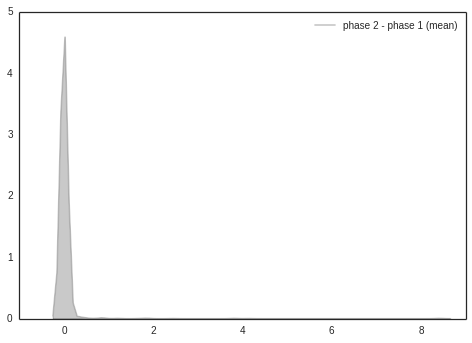

In [27]:
#note: this is how i chose the threshold for flux differences (mean vs kde)
series = abs(flux_shift_stats_dict['20aas'].p2mean - flux_shift_stats_dict['20aas'].p1mean)
#series.plot(kind='kde')
sns.kdeplot(series, shade=True, color=c8, alpha=0.7,label='phase 2 - phase 1 (mean)')

series = abs(flux_shift_stats_dict['20aas'].p2mean - flux_shift_stats_dict['20aas'].p1mean)

factor_up = .5
factor_down = .5

print "Mean:", series.mean()
print "Median:", series.median()
print "std:", series.std()
print "Factor x chosen:", factor_up
print "Threshold up (mean + x*std): ", series.mean() + factor_up*series.std()
print "Threshold down (mean - x*std):", series.mean() - factor_down*series.std()
print "Percent of population above/below threshold:", np.true_divide(series[series > series.mean() + factor_up*series.std()].count() + series[series < series.mean() - factor_up*series.std()].count(), len(series))


In [64]:
# Compute Z score per reaction difference between phases
DF_reaction_zscore

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        DF_reaction_zscore[strain] = get_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m,flux_shift_stats_dict,strain)
        
DF_reaction_zscore['20aas'][0:10]


***PROGRESS: 2133/2134 reactions***



KeyError: '20aas'

In [65]:
DF_reaction_zscore['20aas'][0:10]

,reaction,z_score
0,DM_4crsol_c,0.10
1,DM_5drib_c,0.10
2,DM_amob_c,0.10
3,DM_mththf_c,0.10
4,DM_oxam_c,0.10
5,BIOMASS_Ec_iJO1366_WT_53p95M,0.09
6,BIOMASS_Ec_iJO1366_core_53p95M,0.10
7,EX_12ppd__R_e,0.13
8,EX_12ppd__S_e,0.09
9,EX_15dap_e,0.09


In [70]:
# Compute met Z scores
DF_metabolite_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        DF_metabolite_zscore[strain] = get_met_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m, flux_shift_stats_dict, DF_reaction_zscore, strain)
         
DF_metabolite_zscore['20aas'][0:10]


***PROGRESS: 1667/1973 metabolites***



,metabolite,num_rxns_involved,zscore
0,10fthf_c,7,0.06
1,12dgr120_c,3,0.15
2,12dgr140_c,3,0.16
3,12dgr141_c,3,0.15
4,12dgr160_c,3,0.18
5,12dgr161_c,3,0.18
6,12dgr180_c,3,0.15
7,12dgr181_c,3,0.14
8,12ppd__R_c,3,0.17
9,12ppd__S_c,2,0.16


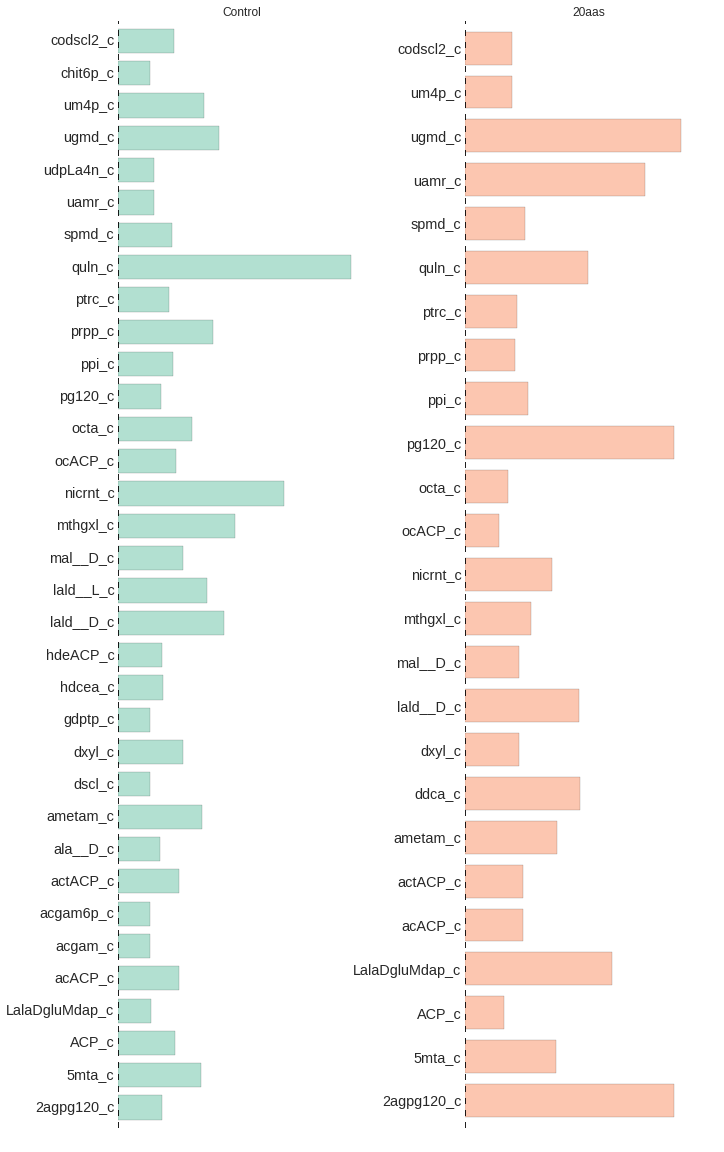

In [100]:
metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'Metabolite_zscores_phases'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis

c1, c2 = sns.color_palette("Set2", 2)

strain = "Control"
df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.76]

df.zscore.plot(ax=axes[0], kind='barh', color=c1, title='Control',alpha=0.5,figsize=(5, 8))

axes[0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = '20aas'

df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.76]

df.zscore.plot(ax=axes[1], kind='barh', color=c2, title='20aas',alpha=0.5,figsize=(5, 8))
axes[1].axis('off')
for i, x in enumerate(df.metabolite):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(17)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


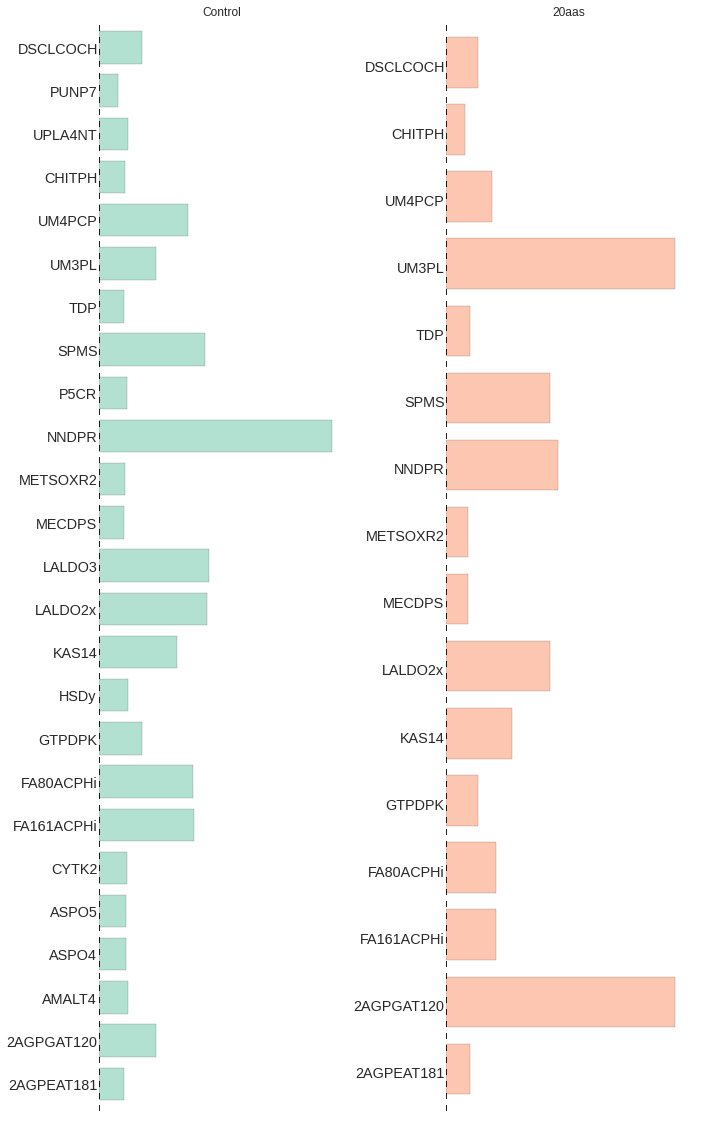

In [90]:
##########################################################
name_graph = 'Reaction_zscores_phases'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis
c1, c2 = sns.color_palette("Set2", 2)

strain = "Control"
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76]
    
#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[0], kind='barh', color=c1, title=strain,alpha=0.5,figsize=(5, 7))
axes[0].axis('off')

for i, x in enumerate(df.reaction):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = '20aas'
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76]

#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[1], kind='barh', color=c2, title=strain,alpha=0.5,figsize=(5, 7))
axes[1].axis('off')
for i, x in enumerate(df.reaction):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')
     
fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(17)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


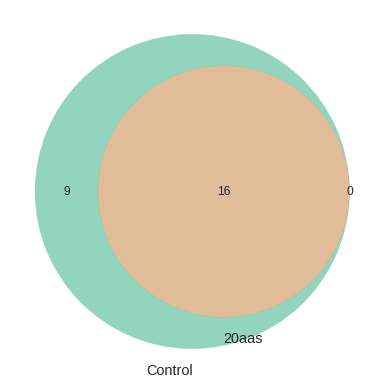

In [104]:
## Veen figures

from matplotlib_venn import venn2, venn2_circles

name_graph = 'Overlaps_reaction_z_score'

#fig, axes = plt.subplots(nrows=1, ncols=3)  # change for adding in bis
fig = plt.figure()
c1, c2 = sns.color_palette("Set2", 2)


ax1=fig.add_subplot(1,1,1)

strain = 'Control'
set1 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76].tolist()
set1 = set(set1)

strain = '20aas'
set2 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76].tolist()
set2 = set(set2)

v = venn2([set1, set2], ('Control', '20aas'),ax=ax1)
v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('100').set_color(c1)
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('010').set_color(c2)

ax1.axis('off')

fig.tight_layout()
fig = plt.gcf()

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

p1
Sample size for p1 I: (2786, 5000)
Sample size for p1 II: (2786, 5000)
number of reactions in df: 2134
Strain p1 (5000, 2036)
Strain p1 (5000, 2036)
p2
Sample size for p2 I: (2786, 5000)
Sample size for p2 II: (2786, 5000)
number of reactions in df: 2134
Strain p2 (5000, 2036)
Strain p2 (5000, 2036)


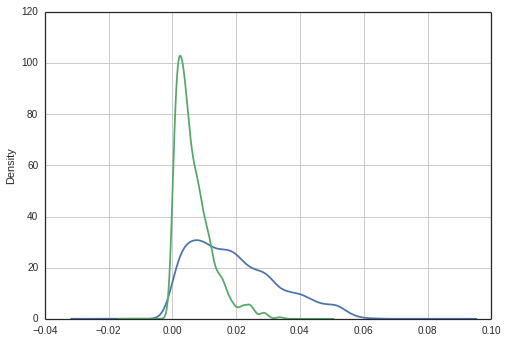

In [116]:
#################################################
#
## flux shift identifying between different culture conditions for a given phase
#

mcmc_reduced_dict_p1 = {}
mcmc_reduced_dict_p2 = {}

mcmc_p1_dict = {}
mcmc_p2_dict = {}

mylegend = ['p1','p2'] # deal with flux shift identifying between different culture conditions

for strain in mylegend:
    print strain
    (mcmc_p1_dict[strain],mcmc_p2_dict[strain]) = mcmc_tab2pandas(strain)
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    df_reduced_p2 = remove_unwanted_rxns(mcmc_p2_dict[strain],reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    mcmc_reduced_dict_p2[strain] = df_reduced_p2
    #mcmc_reduced_dict_p3[strain] = df_reduced_p3
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p2[strain].shape
    #print "Strain", strain, shape(mcmc_reduced_dict_p3[strain])


## Example of how to access flux distributions from data
from matplotlib.pyplot import savefig

react = 'ENO'

mcmc_reduced_dict_p1['p1'][react].plot(kind='density')
mcmc_reduced_dict_p2['p1'][react].plot(kind='density')

savefig('ENO.jpg')

In [120]:
mcmc_reduced_dict_p1.keys()

['p2', 'p1']

In [121]:

df_rxns_removed_p1 = {}
df_rxns_removed_p2 = {}

df_rxns_high_flux_remain_p1 = {}
df_rxns_high_flux_remain_p2 = {}

for strain in mcmc_reduced_dict_p1.keys():
    
    print "shape before pruning %s:"%strain, 
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    [mcmc_reduced_dict_p2[strain], df_rxns_removed_p2[strain], df_rxns_high_flux_remain_p2[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p2[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape


shape before pruning p2: (5000, 2036)
shape after pruning p2: (5000, 1966)
shape before pruning p2: (5000, 2036)
shape after pruning p2: (5000, 1965)
shape before pruning p1: (5000, 2036)
shape after pruning p1: (5000, 1964)
shape before pruning p1: (5000, 2036)
shape after pruning p1: (5000, 1966)


In [123]:
mcmc_redued_dict_p2.keys()

['p2', 'p1']

In [125]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['p1']

for i in df.index:
    if df['percent of states with flux < 10'][i] < 9900:
        print df['react_id'][i], df['percent of states with flux < 10'][i]

for i in df.index:
    if df['percent of states with flux < 10'][i] <10000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]


AOBUTDs 0
APRAUR 0
ARBt3ipp 0
AST 0
ATPM 0
ATPPRT 0
BTNtex 0
BTS5 0
CLt3_2pp 0
CMtpp 0
CO2tex 0
CO2tpp 3
DAPtex 0
DASYN141 0
DHORD5 315
DHORDfum 312
DIMPtex 0
DTMPK 0
DURItex 0
EX_indole_e 3114
EX_ins_e 3115
EX_tartr__L_e 3735
EX_thr__L_e 0
FDH5pp 0
FE2abcpp 0
FE2t3pp 0
FE3HOXUtex 0
FE3HOXUtpp 0
FE3HOXabcpp 0
FEOXAMtonex 0
FLDR2 0
FORt2pp 0
GLYALDDr 0
I2FE2SS 3114
IGPS 2894
L_LACtex 0
MCTP1Bpp 0
MDDCP4pp 5
MDDCP5pp 1582
MDH 4
MEOHtex 0
MEOHtrpp 4
METSOX1tex 0
MINCYCtex 0
MINCYCtpp 21
MLDEP2pp 0
MN2tpp 0
MN6PP 0
MOHMT 0
MOX 0
MPTAT 400
NNATr 0
NNDPR 1221
NOVBCNtex 0
NOVBCNtpp 0
NOtpp 0
NTD1 0
NTD10 0
NTD11 0
NTD12 0
NTD1pp 0
OCTDPS 0
OGMEACPD 0
ORNabcpp 0
PA120abcpp 0
PA140abcpp 0
PAPA180pp 0
PAPA181pp 478
PAPSR2 0
PGPP180 0
SULFACtex 0
SULabcpp 0
AOBUTDs 999.737100624
APRAUR 999.797290016
ARBt3ipp 942.602410089
AST 942.652953826
ATPM 999.434592531
ATPPRT 999.434589101
BTNtex 860.02103635
BTS5 999.732535479
CLt3_2pp 982.516486324
CMtpp 998.218366186
CO2tex 999.999884454
CO2tpp 821.75446

In [126]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given culture conditions
# or, between culture conditions1 - culture conditions2 for a given phase
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1_p2 = {}
#flux_stats_dict_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        flux_stats_dict_p1_p2[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain], m, 1, 2)
        #flux_stats_dict_p2_p3[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain], m, 2, 3)

# Note: here we have the mean, median and std for the flux distributions in phases 1 and 2.
# The pval indicates whether the sample difference between these two states is significant.
flux_stats_dict_p1_p2['p1'][0:3]


strain: p2
strain: p1


,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,1.90e-05,1.90e-05,3.15e-08,2.62e-05,2.62e-05,1.30e-08,4.00e-04,DM_4crsol_c
1,4.73e-04,3.70e-04,3.90e-04,1.98e-04,1.56e-04,1.46e-04,5.00e-01,DM_5drib_c
2,2.11e-11,2.49e-11,9.50e-12,1.24e-11,1.90e-13,2.57e-11,3.84e-01,DM_amob_c


Glyceraldehyde-3-phosphate dehydrogenase
['p2', 'p1']
(5000, 1966)


ValueError: array must not contain infs or NaNs

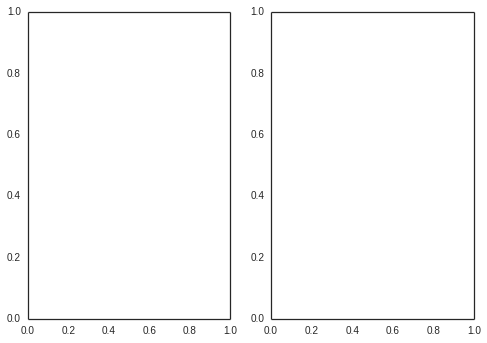

In [127]:
# Plot Shifts

react = 'GAPD'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2, react, 2, -1, 8)


In [128]:
# Classify Flux shifts
flux_stats_dict_p1_p2['p1'][0:1]

flux_shift_stats_dict ={}
m_significant_shifts_dict ={}

for strain in flux_stats_dict_p1_p2.keys():
    print "strain:", strain
    df = flux_stats_dict_p1_p2[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict[strain] = df
    m_significant_shifts_dict[strain] = change
    
print m_significant_shifts_dict['p1'].reaction.values

m_significant_shifts_dict['p1'].subsystem.value_counts()


strain: p2
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1644
do shift 14 

strain: p1
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1640
do shift 17 

['2AGPEAT181' 'ASPO4' 'ASPO5' 'FA161ACPHi' 'FA80ACPHi' 'FLVRx' 'GLUTRS'
 'I2FE2SR' 'KAS14' 'LALDO3' 'LIPAHTex' 'MOAT2' 'NNDPR' 'P5CR' 'TALA' 'TDP'
 'UM4PCP']


Cofactor and Prosthetic Group Biosynthesis     7
Cell Envelope Biosynthesis                     2
Lipopolysaccharide Biosynthesis / Recycling    2
Pentose Phosphate Pathway                      1
Arginine and Proline Metabolism                1
Murein Recycling                               1
Glycerophospholipid Metabolism                 1
Membrane Lipid Metabolism                      1
Methylglyoxal Metabolism                       1
dtype: int64

In [129]:
print m_significant_shifts_dict['p2'].reaction.values

m_significant_shifts_dict['p2'].subsystem.value_counts()


['2AGPGAT120' 'ASPO4' 'ASPO5' 'FA161ACPHi' 'FA80ACPHi' 'FLVRx' 'I2FE2SR'
 'LIPAHTex' 'METSOXR2' 'NNDPR' 'P5CR' 'TALA' 'UM3PL' 'UM4PCP']


Cofactor and Prosthetic Group Biosynthesis     5
Cell Envelope Biosynthesis                     2
Murein Recycling                               2
Pentose Phosphate Pathway                      1
Glycerophospholipid Metabolism                 1
Arginine and Proline Metabolism                1
Methionine Metabolism                          1
Lipopolysaccharide Biosynthesis / Recycling    1
dtype: int64

Mean: 0.0281173782321
Median: 0.00041
std: 0.241288839201
Factor x chosen: 0.5
Threshold up (mean + x*std):  0.148761797832
Threshold down (mean - x*std): -0.0925270413683
Percent of population above/below threshold: 0.0204449789537


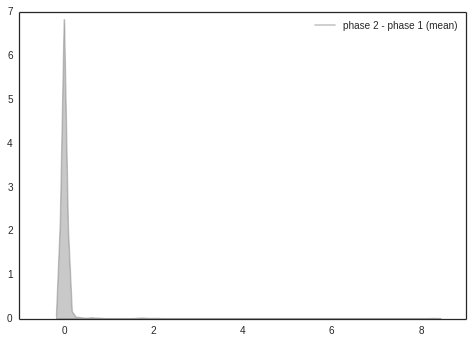

In [130]:
#note: this is how i chose the threshold for flux differences (mean vs kde)
series = abs(flux_shift_stats_dict['p1'].p2mean - flux_shift_stats_dict['p1'].p1mean)
#series.plot(kind='kde')
sns.kdeplot(series, shade=True, color=c8, alpha=0.7,label='phase 2 - phase 1 (mean)')

series = abs(flux_shift_stats_dict['p1'].p2mean - flux_shift_stats_dict['p1'].p1mean)

factor_up = .5
factor_down = .5

print "Mean:", series.mean()
print "Median:", series.median()
print "std:", series.std()
print "Factor x chosen:", factor_up
print "Threshold up (mean + x*std): ", series.mean() + factor_up*series.std()
print "Threshold down (mean - x*std):", series.mean() - factor_down*series.std()
print "Percent of population above/below threshold:", np.true_divide(series[series > series.mean() + factor_up*series.std()].count() + series[series < series.mean() - factor_up*series.std()].count(), len(series))

In [131]:
# Compute Z score per reaction difference

DF_reaction_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        DF_reaction_zscore[strain] = get_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m,flux_shift_stats_dict,strain)
            
DF_reaction_zscore['p1'][0:10]


***PROGRESS: 2133/2134 reactions***

strain: p2


TypeError: get_met_zscore() takes exactly 6 arguments (5 given)

In [132]:
# Compute met Z scores
DF_metabolite_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        DF_metabolite_zscore[strain] = get_met_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m, flux_shift_stats_dict, DF_reaction_zscore,strain)
         
DF_metabolite_zscore['p1'][0:10]


***PROGRESS: 1667/1973 metabolites***



,metabolite,num_rxns_involved,zscore
0,10fthf_c,7,0.04
1,12dgr120_c,3,0.12
2,12dgr140_c,3,0.16
3,12dgr141_c,3,0.16
4,12dgr160_c,3,0.20
5,12dgr161_c,3,0.17
6,12dgr180_c,3,0.16
7,12dgr181_c,3,0.11
8,12ppd__R_c,3,0.02
9,12ppd__S_c,2,0.14


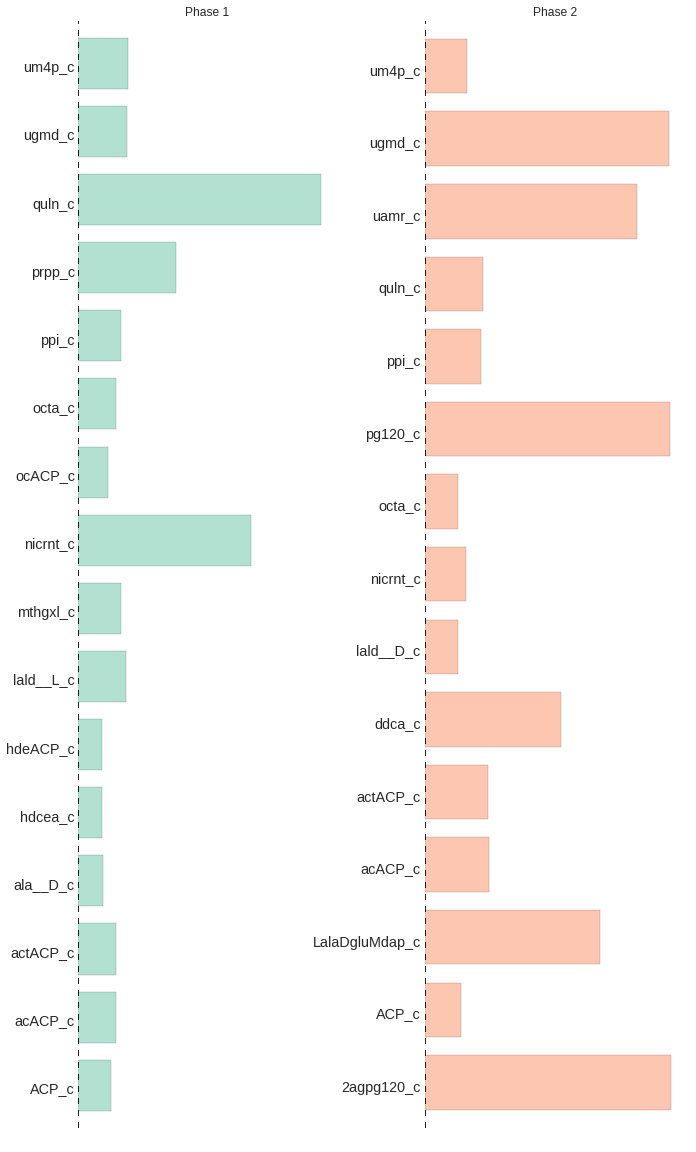

In [134]:
metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'Metabolite_zscores_culture_conditions'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis

c1, c2 = sns.color_palette("Set2", 2)

strain = "p1"
df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.76]

df.zscore.plot(ax=axes[0], kind='barh', color=c1, title="Phase 1",alpha=0.5,figsize=(5, 8))

axes[0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = 'p2'

df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.76]

df.zscore.plot(ax=axes[1], kind='barh', color=c2, title="Phase 2",alpha=0.5,figsize=(5, 8))
axes[1].axis('off')
for i, x in enumerate(df.metabolite):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(17)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


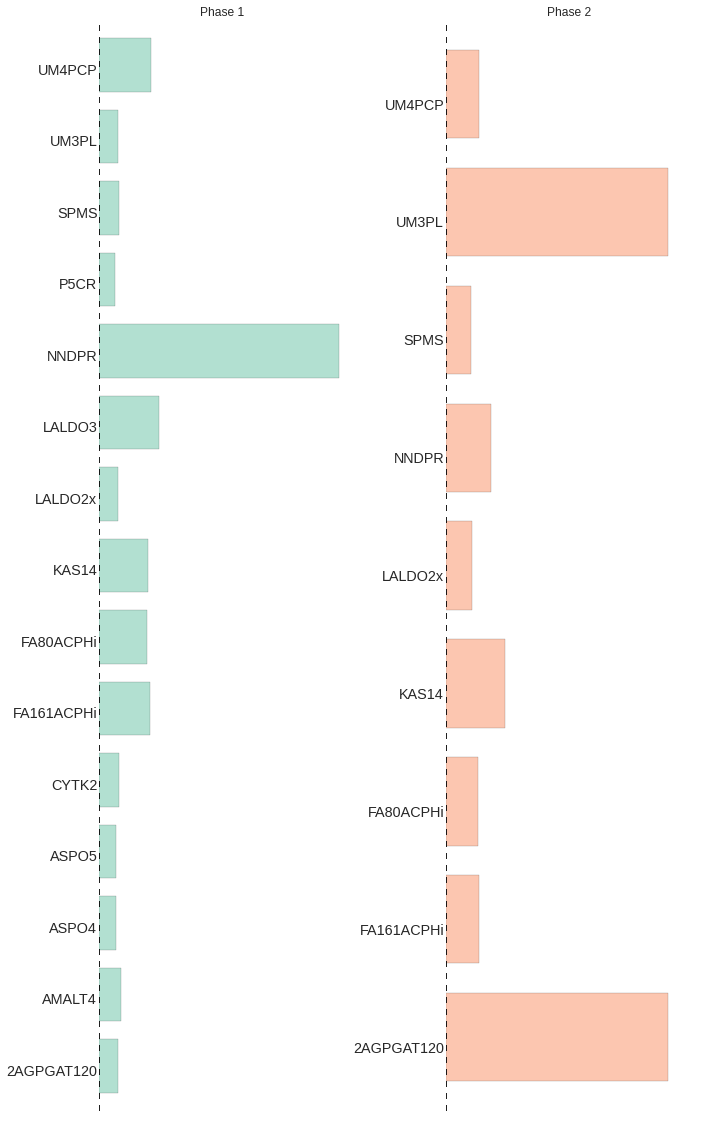

In [135]:
##########################################################
name_graph = 'Reaction_zscores_culture_conditions'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis
c1, c2 = sns.color_palette("Set2", 2)

strain = "p1"
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76]
    
#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[0], kind='barh', color=c1, title="Phase 1",alpha=0.5,figsize=(5, 7))
axes[0].axis('off')

for i, x in enumerate(df.reaction):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = 'p2'
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76]

#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[1], kind='barh', color=c2, title="Phase 2",alpha=0.5,figsize=(5, 7))
axes[1].axis('off')
for i, x in enumerate(df.reaction):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')
     
fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(17)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

In [ ]:
# Veen figures

from matplotlib_venn import venn2, venn2_circles

name_graph = 'Overlaps_reaction_z_score_culture_conditions'

#fig, axes = plt.subplots(nrows=1, ncols=3)  # change for adding in bis
fig = plt.figure()
c1, c2 = sns.color_palette("Set2", 2)


ax1=fig.add_subplot(1,1,1)

strain = 'Phase 1'
set1 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76].tolist()
set1 = set(set1)

strain = 'Phase 2'
set2 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.76].tolist()
set2 = set(set2)

v = venn2([set1, set2], ('Phase 1', 'Phase 2'),ax=ax1)
v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('100').set_color(c1)
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('010').set_color(c2)

ax1.axis('off')

fig.tight_layout()
fig = plt.gcf()

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')